In [42]:
import folium
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

Importing trip data for March 2016 and Weather data from Weather Underground. 

The source data is read in a separate Python class. It is manipulated as a DataFrame and finally exported into Parquet (or Feather) format. Both parquet and feather are well supported but parquest has wider acceptance at this moment. I also noticed that parquet files compress better with snappy. To know more about Feather, read https://blog.rstudio.org/2016/03/29/feather/

The ETL part of the analysis is in a separate file (CitiBike_ETL.py). It reads all .csv files and converts it into parquet. We could also have partioned the parquet files based on the column we'll be joining with other datasets. But for this analysis, I have not partitioned as I'm analysing just a month's data. During analysis, this notebook will be run multiple times and it is efficient to just import the DataFrame

Importing trip data for March 2016 and Weather data from Weather Underground

In [3]:
# Read the data files
#bikedata = pd.read_csv('../../Data/CitiBike_Data/201603-citibike-tripdata.csv')
bikedata = pd.read_parquet("./data/bikedata_201603.parquet")
weather = pd.read_csv('./data/temperature/weather.csv')

In [5]:
# Drop the unnamed column
weather.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Data manipulation
# Making both the keys in the dataframes of same type (<type 'datetime.date'>)
bikedata['dtstarttime'] = pd.to_datetime(bikedata.starttime, format="%m/%d/%Y %H:%M:%S")
bikedata['dtstoptime'] = pd.to_datetime(bikedata.stoptime, format="%m/%d/%Y %H:%M:%S")
bikedata['date'] = bikedata.dtstarttime.dt.date
weather['date'] = pd.to_datetime(weather.date, format="%Y-%m-%d").dt.date

# Set the startdate and stopdate - minutes and seconds reset to 0 (in the following format - 2016-03-01 06:00:00)
# This has been done so that we could aggregate departures and arrivals per hour to identify bike usage
bikedata['dtstartdatehour'] = bikedata.dtstarttime.apply(lambda x:x.replace(minute=0,second=0))
bikedata['dtstopdatehour'] = bikedata.dtstoptime.apply(lambda x:x.replace(minute=0,second=0))

In [15]:
bikedata.dtypes

tripduration                        int64
starttime                          object
stoptime                           object
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                        float64
male                                int64
female                              int64
dtstartdatehour            datetime64[ns]
dtstarttime                datetime64[ns]
dtstoptime                 datetime64[ns]
date                               object
dtstopdatehour             datetime64[ns]
dtype: object

<br/>

**At what time are they busy?**
<br/>As we can see below in the graph, the busies times in the month of March are 8-10 am and 5-6 pm

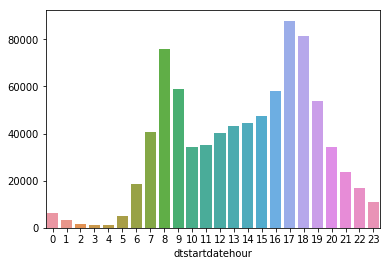

In [29]:
aggByHour = bikedata.groupby(by=bikedata.dtstartdatehour.dt.hour).count()['start station id']
sns.barplot(aggByHour.index, aggByHour.values)

**Which Start and End stations are the busiest?**

As you can see below, the busiest start and end stations are almost the same ones. So, the bike company should employ more staff in these stations

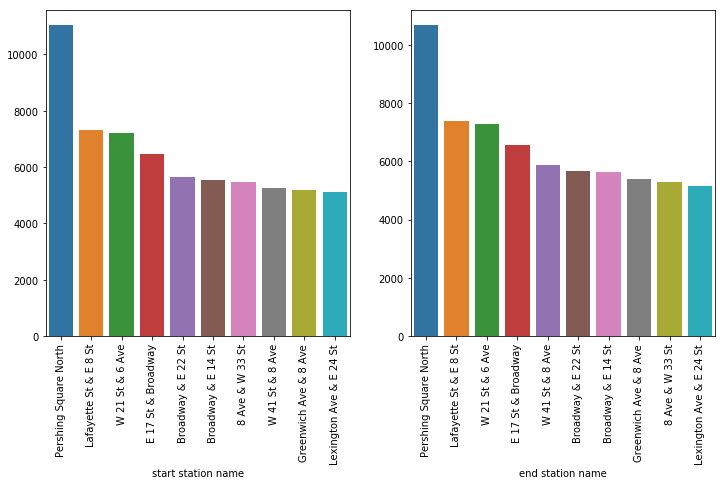

In [57]:
aggByStartSt = bikedata.groupby(by=['start station name']).count()['start station id'].sort_values(ascending=False).head(10)
aggByEndSt = bikedata.groupby(by=['end station name']).count()['end station id'].sort_values(ascending=False).head(10)

f, axes = plt.subplots(1,2,figsize=(12, 6))

g1 = sns.barplot(aggByStartSt.index, aggByStartSt.values, ax=axes[0])\
.set_xticklabels(aggByStartSt.index, rotation=90)

g2 = sns.barplot(aggByEndSt.index, aggByEndSt.values, ax=axes[1])\
.set_xticklabels(aggByEndSt.index, rotation=90)

In [ ]:
# Merging weather and bike data
df = pd.merge(bikedata, weather, on='date', how='left')
df.dtypes

## Initial Data Analysis

#### How many trips start and end at the same station?

We can see that only 1.67% of the bikes start and end at the same station

In [7]:
float(len(df[df['start station id'] == df['end station id']]))*100/len(df)

1.6760134837665408

#### Which Start and End stations are the busiest?

In [8]:
df.groupby(by=['start station id'])['bikeid'].count().sort_values(ascending=False).head()

start station id
519    11634
293     7721
435     7493
497     6888
426     6006
Name: bikeid, dtype: int64

In [9]:
# df['dtstarttime'] = pd.to_datetime(df.starttime, format="%m/%d/%Y %H:%M:%S")
# Extract the Hour component from starttime and stoptime
startHour = df.starttime.str.split().str[1].str.split(':').str[0].astype('int')
endHour = df.stoptime.str.split().str[1].str.split(':').str[0].astype('int')

# All data where starttime' hour is before 9 am
# dfStopBeforeTen = df[endHour <= 9]

# All data where starttime' hour is after 4 pm
# dfStartAfterFour = df[startHour >= 16]

In [10]:
dfMorning = df[endHour <= 10]
dfEvening = df[endHour >= 16]

dfMorningStart = dfMorning.groupby(by=['start station id'])['bikeid'].count().sort_values(ascending=False)
dfMorningEnd = dfMorning.groupby(by=['end station id'])['bikeid'].count().sort_values(ascending=False)

dfEveningStart = dfEvening.groupby(by=['start station id'])['bikeid'].count().sort_values(ascending=False)
dfEveningEnd = dfEvening.groupby(by=['end station id'])['bikeid'].count().sort_values(ascending=False)

In [11]:
topN = 750

# We are finding the top N start and end stations id before 10am
dfTopMorningStart = dfMorningStart[dfMorningStart > topN]
dfTopMorningEnd = dfMorningEnd[dfMorningEnd > topN]

# We are finding the top N start and end stations id ater 4pm
dfTopEveningStart = dfEveningStart[dfEveningStart > topN]
dfTopEveningEnd = dfEveningEnd[dfEveningEnd > topN]

netMorningSource = df[df['end station id'].isin(dfTopMorningStart.index.values)]
netMorningSink = df[df['end station id'].isin(dfTopMorningEnd.index.values)]

netEveningSource = df[df['end station id'].isin(dfTopEveningStart.index.values)]
netEveningSink = df[df['end station id'].isin(dfTopEveningEnd.index.values)]


In [12]:
# Plotting just the morning traffic
# We can see that Net Sinks (red) are concentrated in the middle of NY, where most of the offices are
netMorningSourcePoints = netMorningSource[['start station latitude', 'start station longitude']]
netMorningSinkPoints = netMorningSink[['end station latitude', 'end station longitude']]

netMorningSourcePointsToPlot = netMorningSourcePoints.drop_duplicates()
netMorningSinkPointsToPlot = netMorningSinkPoints.drop_duplicates()

nyMapMorning = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

for index, row in netMorningSourcePointsToPlot.iterrows():
    folium.CircleMarker([row.get(0), row.get(1)], radius=20, color='green').add_to(nyMapMorning)

for index, row in netMorningSinkPointsToPlot.iterrows():
    folium.CircleMarker([row.get(0), row.get(1)], radius=20, color='red').add_to(nyMapMorning)

nyMapMorning

In [13]:
# Plotting just the evening traffic
netEveningSourcePoints = netEveningSource[['start station latitude', 'start station longitude']]
netEveningSinkPoints = netEveningSink[['end station latitude', 'end station longitude']]

netEveningSourcePointsToPlot = netEveningSourcePoints.drop_duplicates()
netEveningSinkPointsToPlot = netEveningSinkPoints.drop_duplicates()

nyMapEvening = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

for index, row in netEveningSourcePointsToPlot.iterrows():
    folium.CircleMarker([row.get(0), row.get(1)], radius=20, color='green').add_to(nyMapEvening)

for index, row in netEveningSinkPointsToPlot.iterrows():
    folium.CircleMarker([row.get(0), row.get(1)], radius=20, color='red').add_to(nyMapEvening)

nyMapEvening